# Редькина Я.Б. Группа ВВО-19
Версия 3.0 (21.12.2022)

In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [81]:
pd.set_option('display.float_format', '{:,.5f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Загрузка данных

In [82]:
df = pd.read_csv('exam_dataset.csv', encoding = 'cp1251', delimiter=';', decimal=',')

In [83]:
df.head()

,snapshot_dt,agreement,customer,f_triggered,a76154d74182dbdbe69cc30b71b94709,713bc35ae4a64ec4790712ab3ff2e7b0,142642bce57cac3a54f26d9c4a4ea164,64879933ebbcd196512dd71dede1b7fc,41b8f61fa021d3421510284f8e8ed8e6,d70cf72daf09e847b9d98f5cd110e874,47b359b06b472245ebf392f89c1984d9,a4fc43c630d53f6b4fc24dcea3cdfdd6,20954702b0ca458c1b9cc94a2149dfae,d1e92bd0813153b4426efe76c284962a,96ac93b9d41855f8f4154d101b7eec8f,60678ed309bcdf3a7f66c3c0eaaa1008,dc22bcce783424523515ca0e767f956d,de21a72f92151bd934313db21484d8db,6e3c7ee1446922e9affc2dec6d8515f5,3ab7560edc855076c9f82a1d067260ac,c4e258b20763ff2f5eb3a9c0051b79f9,713c06ee08e923ef1deb2b49e6412d08,56c259bfa606793bcebaab86f6b85433,738c9267ed0535b048c9b4e6ecff0fb4,1674cc7109143930d7062cf2bd15bc7a,b55cf545a7986b074431f2d871729ce9,e5b53d22fc96aa7d26dc24ae635738e3,1d211cea131c727b11e844a32fecdf60,e2797b202accd48208bb55c5f42b3bd3,40420d27d2213916d22d5667fa9cc79d,56b9387690aec4bea7c0ead0cd2e24f7,0866c8069f8eb9325d7aff3bc11aa4c6,d34fdde10bbb782474b10a70e8afe0f1,74035d01c87ff94f92a02d8b4c96db89,9592aaf089727a294080f269ded5b792,8ba3cf3fe186dd2da23b957bb173138a,0ca8d1267d125b2168c4d63e02f5af1e,3c267b3313e203bfca261907cbeda7f9,fc0ded9709cc8e822e4e3d5fd6e0eec2,6b5813ceabe68652ddab5a4aa9b721e0,c82fc9c0e6b2751df53d7dd5c468de67,cb943d8843fff2f8467e9302993102de,c6f4e2f63b588bd5687ea6355b58b715,a7e2d20b01d09c3dc6c3e7597ba74ab3,234f65a21bdae522ae9e58d00af11dcf,519053282a77e76f836c4e2de8b729e1,f9608069a551280acfd81ef612ffaaa3,51cb8124c134e01bff98d8e796f87f5a,8e78b08a9f5993a6c3ac4bceef7a8dd8,5d16d06d10a707e2fcdec6f8fc8c4430,d459ebf68fc2817262bbdf585ee417fa,754dee610d3bc5ef654ef2b9c4328c2d,3bd82d077c83e58e0682d35477517cf0,e4c6835684496e9fa5c8292c8bcaa4b3,b595cbe5ed2d1a3b983c039ae8ff405f,26ead531bb1ccaad478f1989fc1c8d9b,b62f1cae6504d09ae4456042bc924802,cbdcd5b4417b44615f4205f532c09bf8,de41cfed08599c3ed288a56edcc5c768,7218c484a45b5cf830285bff9b436a9e,9a97b46bc29290671213a1d7f21016b9,8ce7e1924c8891f9ca267c926a71d4ad,7e9b2e50b011024e81f5c646fb436e28,bb496ecdfaf5fc8772d00ae34048ec29,5a105e8b9d40e1329780d62ea2265d8a,ad0234829205b9033196ba818f7a872b
0,1525132800,243994109,24006620,0,0.00000,-1.00000,0.00000,018,0.00000,-1.00000,NaN,NaN,-1.00000,NaN,NaN,NaN,-1.00000,0.11249,0.00000,NaN,0.00000,NaN,0,NaN,2,-1.00000,-1.00000,0.00000,-1.00000,-1.00000,17.00000,-1.00000,-1.00000,NaN,-1.00000,-1.00000,NaN,NaN,NaN,-1.00000,0.00000,0.00000,-1.00000,-1.00000,-1.00000,-1.00000,0.00000,-1.00000,0.00000,-1.00000,-1.00000,NaN,0.00000,-1.00000,-1.00000,-1.00000,018,0.00000,-1.00000,0.00000,-1.00000,1.00000,-1.00000,NaN,1,1
1,1543622400,360081744,219930273,0,1.00000,0.15990,0.00000,01A,21.62523,-1.00000,NaN,NaN,0.00000,NaN,NaN,NaN,-1.00000,0.00000,0.00000,NaN,0.05607,NaN,0,NaN,6,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,17.00000,-1.00000,-1.00000,NaN,-1.00000,-1.00000,NaN,NaN,NaN,-1.00000,0.40865,0.01869,0.00000,-1.00000,-1.00000,-1.00000,0.00000,0.00000,"2,501.00000",-1.00000,-1.00000,NaN,0.00000,-1.00000,-1.00000,0.00000,01C,0.00000,-1.00000,0.00000,-1.00000,0.00000,-1.00000,NaN,0,1
2,1535760000,163557019,22068418,0,inf,0.99435,0.00000,01A,12.21154,-1.00000,NaN,NaN,inf,NaN,NaN,NaN,-1.00000,0.11170,0.06731,NaN,0.00000,NaN,0,NaN,5,-1.00000,-1.00000,0.00000,-1.00000,-1.00000,17.00000,-1.00000,-1.00000,NaN,0.75000,-1.00000,NaN,NaN,NaN,-1.00000,2.06210,0.02885,1.50000,2.33333,-1.00000,-1.00000,0.00000,1.00000,0.00000,-1.00000,-1.00000,NaN,0.00000,-1.00000,-1.00000,inf,019,0.00000,-1.00000,0.00000,-1.00000,0.00000,-1.00000,NaN,1,1
3,1551398400,381683214,262085392,0,0.00000,inf,1.61290,NaN,0.00000,-1.00000,0.00000,NaN,-1.00000,0.00000,NaN,NaN,-0.46392,3.34294,0.00000,NaN,0.00000,NaN,0,0.00000,0,-1.00000,0.00000,0.33333,-1.00000,0.00000,17.00000,0.00000,-1.00000,‹Ћ†њ,-1.00000,0.00000,0.00000,NaN,NaN,0.00000,1.13528,0.08065,-1.00000,3.00000,0.00000,0.00000,0.00000,2.00000,862.12000,0.00000,-0.23196,-1.00000,0.00000,-1.00000,-1.00000,inf,NaN,0.00000,-1.00000,0.00000,0.80000,0.00000,-1.00000,0.00000,2,2
4,1533081600,117405311,86867150,0,inf,3.

In [84]:
df['f_triggered'].value_counts(dropna=False)

0    98358
1     2008
Name: f_triggered, dtype: int64

Проверили целевую переменную - имеет два значения: это задача классификации.
Причем классы несбалансированы - 98% класса одного класса против 2% другого.

### Обработка данных

In [85]:
#целевая переменная - флаг факта оттока клиента
#номер договора и идентификатор клиента по смыслу не влияют на отток - удаляем эти признаки
df.drop(['agreement', 'customer'], axis=1, inplace=True)

In [86]:
# В значениях присутствует +-inf - заменим на NAN с последующей обработкой пропусков
for column in df.columns:
    df[column].replace([np.inf, -np.inf], np.nan, inplace=True)

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100366 entries, 0 to 100365
Data columns (total 64 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   snapshot_dt                       100366 non-null  int64  
 1   f_triggered                       100366 non-null  int64  
 2   a76154d74182dbdbe69cc30b71b94709  58544 non-null   float64
 3   713bc35ae4a64ec4790712ab3ff2e7b0  81114 non-null   float64
 4   142642bce57cac3a54f26d9c4a4ea164  70705 non-null   float64
 5   64879933ebbcd196512dd71dede1b7fc  100197 non-null  object 
 6   41b8f61fa021d3421510284f8e8ed8e6  70705 non-null   float64
 7   d70cf72daf09e847b9d98f5cd110e874  100169 non-null  float64
 8   47b359b06b472245ebf392f89c1984d9  15486 non-null   float64
 9   a4fc43c630d53f6b4fc24dcea3cdfdd6  1620 non-null    float64
 10  20954702b0ca458c1b9cc94a2149dfae  66487 non-null   float64
 11  d1e92bd0813153b4426efe76c284962a  15486 non-null   f

In [88]:
# Размерность датафрейма
df.shape

(100366, 64)

In [89]:
# Поиск и удаление строк, в которых пропусков (NAN) больше 15
# (только среди класса '0', тк другого класса совсем мало)

for index, row in df.iterrows():
    if (row['f_triggered'] == 0) and (row.isna().sum() > 15):
        df.drop(index, axis=0, inplace=True)

In [91]:
# Поиск и удаление признаков, у которых процент пропусков (NAN) больше 50%

row_count = len(df)
for column in df.columns:
    if df[column].isna().sum() / row_count > 0.5:
        df.drop(column, axis=1, inplace=True)

In [92]:
# Новая размерность датафрейма
df.shape

(45852, 50)

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45852 entries, 0 to 100363
Data columns (total 50 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   snapshot_dt                       45852 non-null  int64  
 1   f_triggered                       45852 non-null  int64  
 2   a76154d74182dbdbe69cc30b71b94709  40975 non-null  float64
 3   713bc35ae4a64ec4790712ab3ff2e7b0  36775 non-null  float64
 4   142642bce57cac3a54f26d9c4a4ea164  45314 non-null  float64
 5   64879933ebbcd196512dd71dede1b7fc  45811 non-null  object 
 6   41b8f61fa021d3421510284f8e8ed8e6  45314 non-null  float64
 7   d70cf72daf09e847b9d98f5cd110e874  45851 non-null  float64
 8   20954702b0ca458c1b9cc94a2149dfae  44032 non-null  float64
 9   dc22bcce783424523515ca0e767f956d  45850 non-null  float64
 10  de21a72f92151bd934313db21484d8db  45544 non-null  float64
 11  6e3c7ee1446922e9affc2dec6d8515f5  45314 non-null  float64
 12  c4e

In [94]:
# Обработка пропусков (у object NAN => unknown, у числовых NAN => mean)
for column in df.columns:
    if df[column].dtype == object:
        df[column].fillna(value="unknown", inplace=True)
    elif df[column].dtype == float:
        df[column].fillna(df[column].mean(),inplace=True)
    else:
        continue

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45852 entries, 0 to 100363
Data columns (total 50 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   snapshot_dt                       45852 non-null  int64  
 1   f_triggered                       45852 non-null  int64  
 2   a76154d74182dbdbe69cc30b71b94709  45852 non-null  float64
 3   713bc35ae4a64ec4790712ab3ff2e7b0  45852 non-null  float64
 4   142642bce57cac3a54f26d9c4a4ea164  45852 non-null  float64
 5   64879933ebbcd196512dd71dede1b7fc  45852 non-null  object 
 6   41b8f61fa021d3421510284f8e8ed8e6  45852 non-null  float64
 7   d70cf72daf09e847b9d98f5cd110e874  45852 non-null  float64
 8   20954702b0ca458c1b9cc94a2149dfae  45852 non-null  float64
 9   dc22bcce783424523515ca0e767f956d  45852 non-null  float64
 10  de21a72f92151bd934313db21484d8db  45852 non-null  float64
 11  6e3c7ee1446922e9affc2dec6d8515f5  45852 non-null  float64
 12  c4e

In [96]:
# Посмотрим на корреляцию числовых призаков
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,snapshot_dt,f_triggered,a76154d74182dbdbe69cc30b71b94709,713bc35ae4a64ec4790712ab3ff2e7b0,142642bce57cac3a54f26d9c4a4ea164,41b8f61fa021d3421510284f8e8ed8e6,d70cf72daf09e847b9d98f5cd110e874,20954702b0ca458c1b9cc94a2149dfae,dc22bcce783424523515ca0e767f956d,de21a72f92151bd934313db21484d8db,6e3c7ee1446922e9affc2dec6d8515f5,c4e258b20763ff2f5eb3a9c0051b79f9,56c259bfa606793bcebaab86f6b85433,1674cc7109143930d7062cf2bd15bc7a,b55cf545a7986b074431f2d871729ce9,e5b53d22fc96aa7d26dc24ae635738e3,1d211cea131c727b11e844a32fecdf60,e2797b202accd48208bb55c5f42b3bd3,40420d27d2213916d22d5667fa9cc79d,56b9387690aec4bea7c0ead0cd2e24f7,0866c8069f8eb9325d7aff3bc11aa4c6,d34fdde10bbb782474b10a70e8afe0f1,9592aaf089727a294080f269ded5b792,8ba3cf3fe186dd2da23b957bb173138a,6b5813ceabe68652ddab5a4aa9b721e0,c82fc9c0e6b2751df53d7dd5c468de67,cb943d8843fff2f8467e9302993102de,c6f4e2f63b588bd5687ea6355b58b715,a7e2d20b01d09c3dc6c3e7597ba74ab3,234f65a21bdae522ae9e58d00af11dcf,519053282a77e76f836c4e2de8b729e1,f9608069a551280acfd81ef612ffaaa3,51cb8124c134e01bff98d8e796f87f5a,8e78b08a9f5993a6c3ac4bceef7a8dd8,5d16d06d10a707e2fcdec6f8fc8c4430,d459ebf68fc2817262bbdf585ee417fa,3bd82d077c83e58e0682d35477517cf0,e4c6835684496e9fa5c8292c8bcaa4b3,b595cbe5ed2d1a3b983c039ae8ff405f,26ead531bb1ccaad478f1989fc1c8d9b,cbdcd5b4417b44615f4205f532c09bf8,de41cfed08599c3ed288a56edcc5c768,7218c484a45b5cf830285bff9b436a9e,9a97b46bc29290671213a1d7f21016b9,8ce7e1924c8891f9ca267c926a71d4ad,7e9b2e50b011024e81f5c646fb436e28,5a105e8b9d40e1329780d62ea2265d8a,ad0234829205b9033196ba818f7a872b
snapshot_dt,1.000000,-0.005997,0.021639,0.012795,0.003249,-0.000712,0.019846,0.032151,-0.002477,0.003001,0.005475,-0.005823,0.116005,0.052666,-0.003044,0.012533,0.006019,0.014685,0.022426,-0.024582,0.003354,-0.000971,0.022043,0.001700,0.004595,0.003275,0.003488,0.026545,0.019838,0.022884,0.004438,-0.049127,0.014798,0.015410,0.066943,0.021716,-0.006656,0.019104,0.009669,0.025004,0.000795,0.002385,0.008561,0.014340,0.007973,-0.019434,0.002175,0.007139
f_triggered,-0.005997,1.000000,0.012889,0.006108,-0.000733,-0.001404,0.010989,0.006956,0.005698,0.043994,0.013480,-0.015873,0.010299,-0.008165,-0.003217,0.021699,-0.007622,0.001502,0.035113,-0.024453,0.001711,0.015362,0.000113,0.004358,0.006056,-0.002364,0.006442,-0.004110,0.028571,0.024306,0.005004,0.000855,-0.030659,0.002799,0.081900,0.035099,0.002835,0.068481,-0.015910,0.010154,0.021202,-0.005427,-0.000935,0.009391,0.017101,0.006597,-0.001209,-0.001564
a76154d74182dbdbe69cc30b71b94709,0.021639,0.012889,1.000000,0.008050,-0.017614,-0.027933,-0.045042,0.102060,0.005307,0.042429,0.011842,-0.071196,0.023533,0.024563,-0.005278,0.026344,0.079535,0.007098,0.038503,-0.000985,0.002174,0.022098,0.285993,-0.009367,-0.005909,0.014972,-0.004874,0.100757,0.211391,0.040595,0.015031,-0.001227,0.275751,0.032120,0.092102,0.038520,0.002169,0.085700,-0.104750,0.263453,0.010891,-0.016293,0.002284,0.053473,0.117571,0.012746,-0.005208,0.001144
713bc35ae4a64ec4790712ab3ff2e7b0,0.012795,0.006108,0.008050,1.000000,-0.000806,-0.001954,-0.001957,-0.001307,0.000336,-0.000956,0.001034,-0.001014,-0.004870,0.001390,-0.000446,0.000983,-0.002205,0.000078,0.001545,-0.001559,0.000100,0.002892,0.004138,0.000127,0.000180,0.000174,0.006816,-0.000187,0.001774,0.001048,0.000267,0.000959,0.010509,-0.001651,0.003404,0.001556,-0.000664,0.003752,-0.007203,0.002166,-0.000171,-0.001319,-0.000118,-0.000590,0.000830,0.002471,-0.007238,0.004181
142642bce57cac3a54f26d9c4a4ea164,0.003249,-0.000733,-0.017614,-0.000806,1.000000,0.001633,0.006729,-0.008154,0.001134,0.000611,-0.004823,-0.017395,0.000387,-0.011626,-0.000632,0.003383,0.000857,-0.002562,0.005264,0.002069,-0.000458,0.003014,-0.021976,0.000243,0.000701,-0.001161,-0.008211,-0.010552,-0.014780,0.003857,0.000733,0.002894,-0.021619,-0.005191,0.011612,0.005302,0.006891,-0.003579,-0.007747,-0.014443,0.003146,0.000006,-0.000409,-0.003755,-0.014122,-0.003136,0.005999,-0.004408
41b8f61fa021d3421510284f8e8ed8e6,-0.000712,-0.001404,-0.027933,-0.001954,0.001633,1.000000,

In [97]:
#Сильно коррелируют:
#d459ebf68fc2817262bbdf585ee417fa <-> 40420d27d2213916d22d5667fa9cc79d (0.995742)
#d459ebf68fc2817262bbdf585ee417fa <-> dc22bcce783424523515ca0e767f956d (0.930237)
#dc22bcce783424523515ca0e767f956d <-> 40420d27d2213916d22d5667fa9cc79d (0.930044)
#8ba3cf3fe186dd2da23b957bb173138a <-> 6b5813ceabe68652ddab5a4aa9b721e0 (0.808584)

#удалим по одному признаку:
df.drop(['40420d27d2213916d22d5667fa9cc79d', '8ba3cf3fe186dd2da23b957bb173138a', 'dc22bcce783424523515ca0e767f956d'], axis=1, inplace=True)

/usr/local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/tools.py:223: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


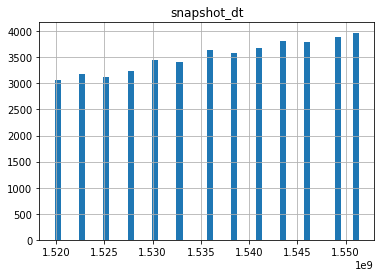

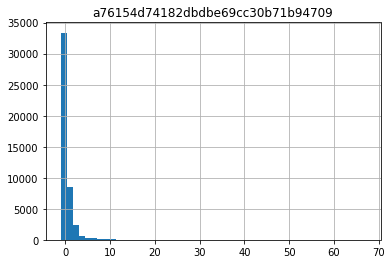

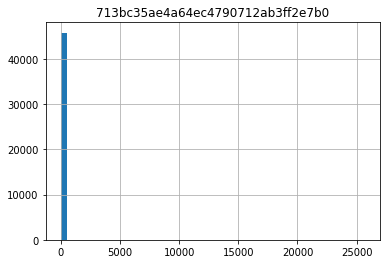

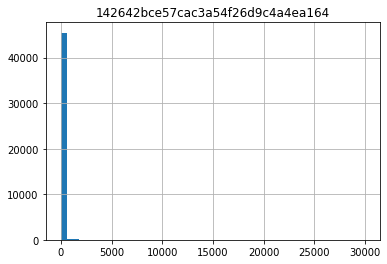

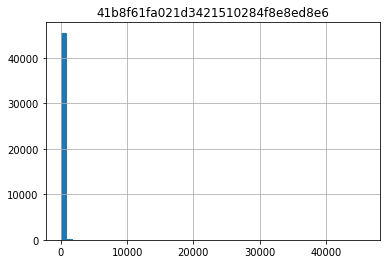

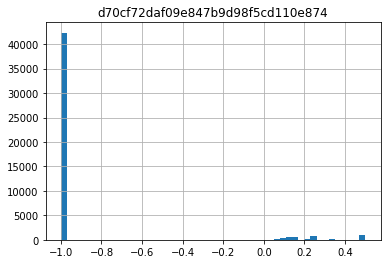

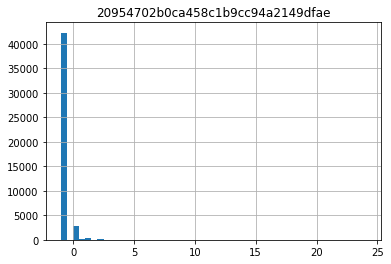

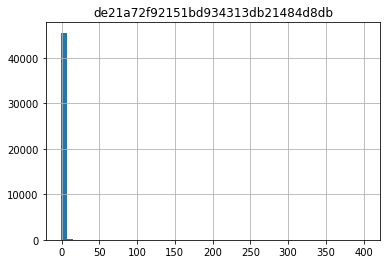

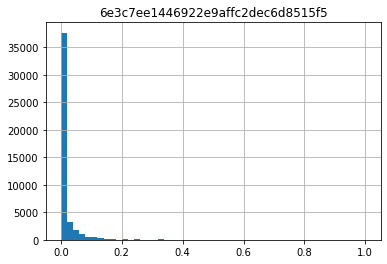

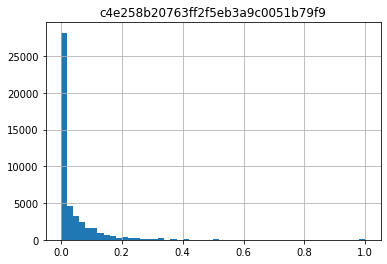

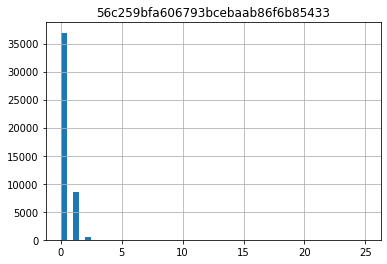

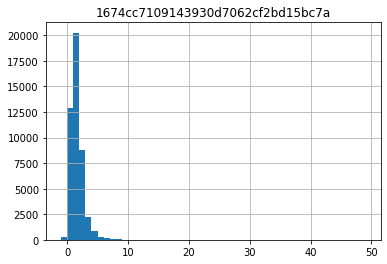

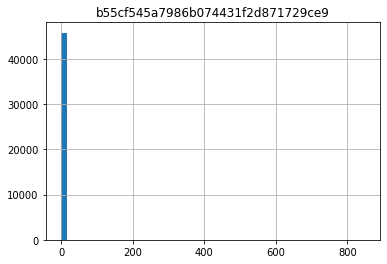

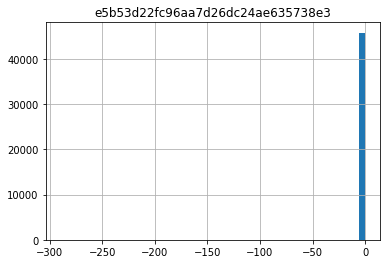

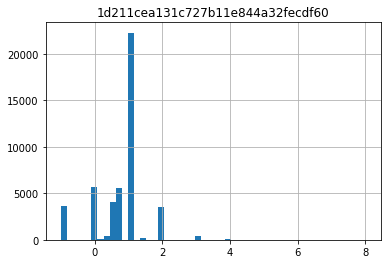

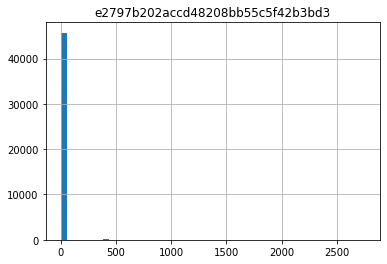

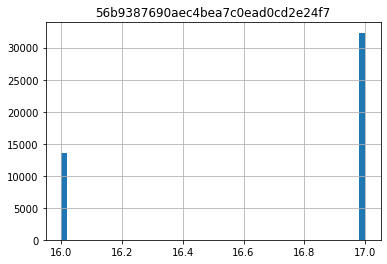

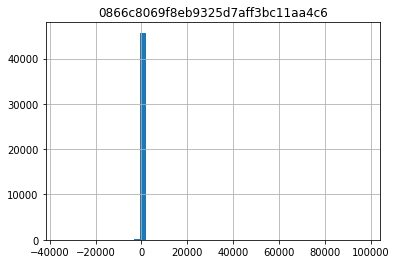

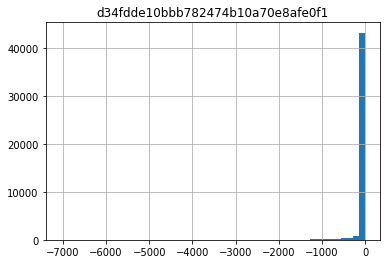

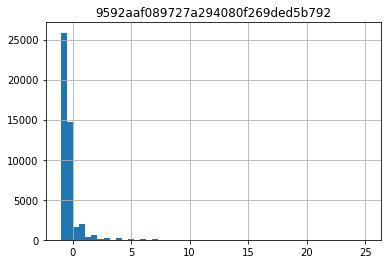

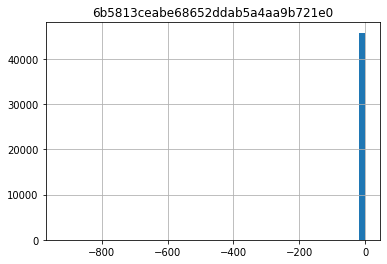

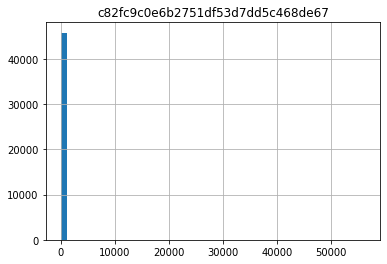

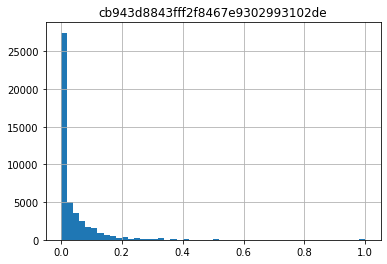

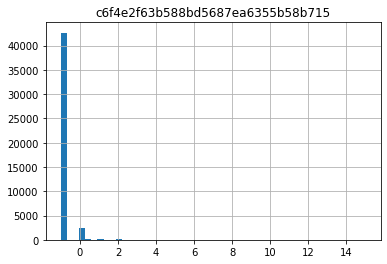

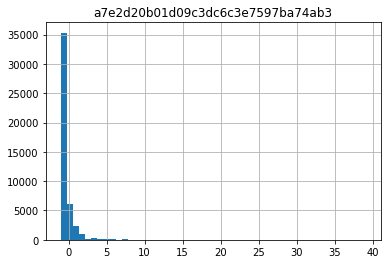

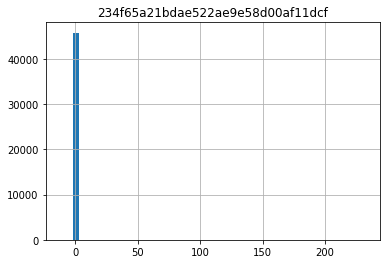

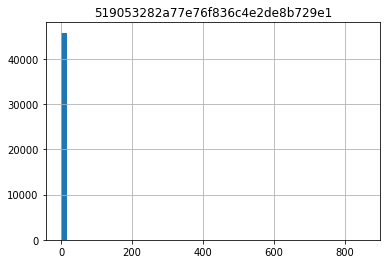

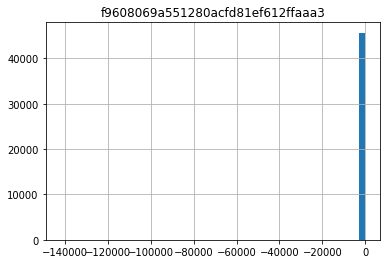

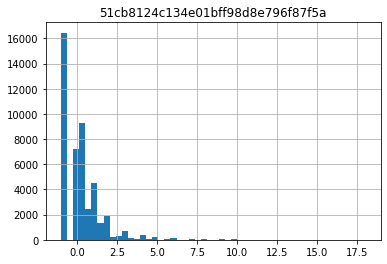

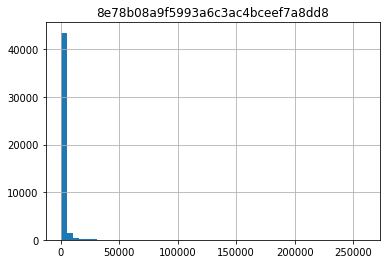

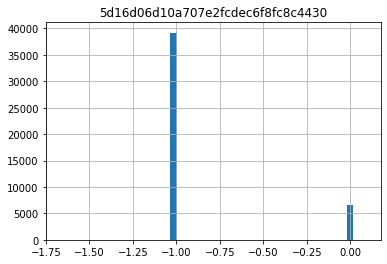

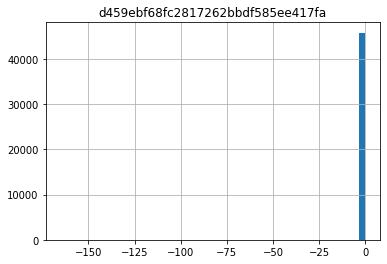

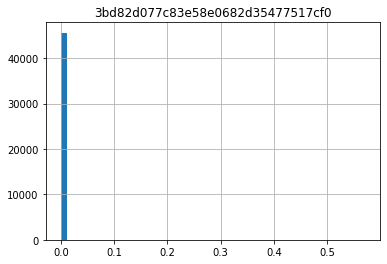

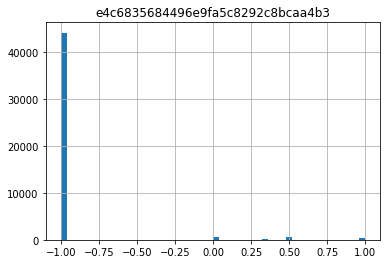

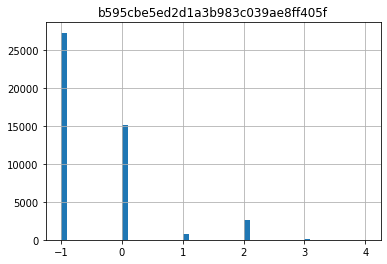

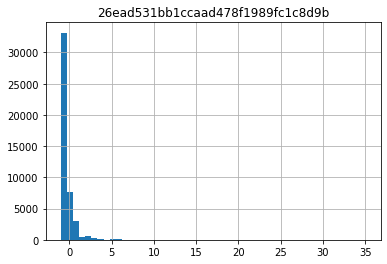

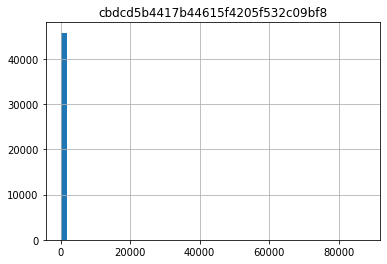

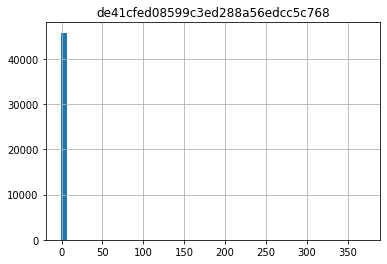

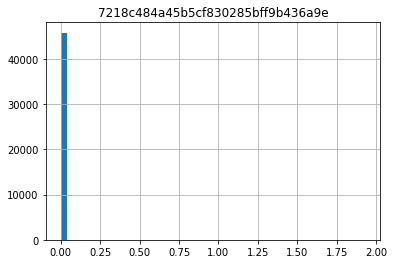

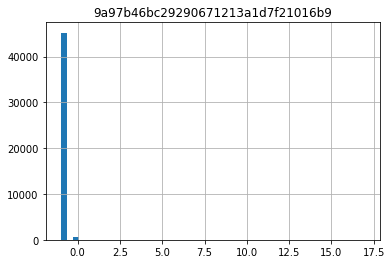

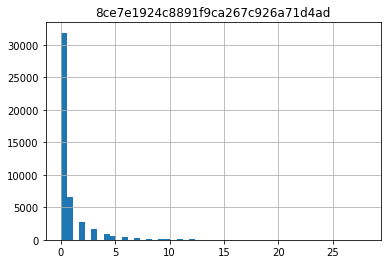

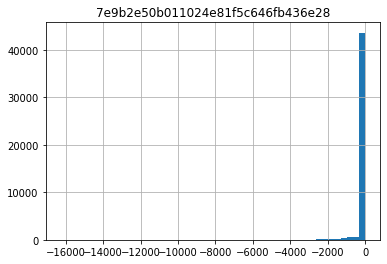

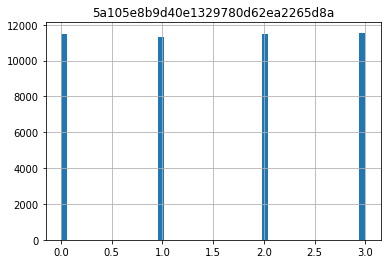

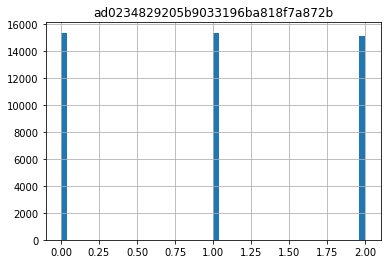

In [18]:
#просмотр гистограммы (ищем выбросы)
df_num = df.drop(['f_triggered','64879933ebbcd196512dd71dede1b7fc', 'b62f1cae6504d09ae4456042bc924802'], axis=1, inplace=False)
for i in df_num.columns:
    df[[i]].hist(bins=50)

In [30]:
#Проверить признаки: 
# 713bc35ae4a64ec4790712ab3ff2e7b0
# 142642bce57cac3a54f26d9c4a4ea164
# 41b8f61fa021d3421510284f8e8ed8e6
# de21a72f92151bd934313db21484d8db
# b55cf545a7986b074431f2d871729ce9
# e2797b202accd48208bb55c5f42b3bd3
# 0866c8069f8eb9325d7aff3bc11aa4c6
# d34fdde10bbb782474b10a70e8afe0f1
# c82fc9c0e6b2751df53d7dd5c468de67
# f9608069a551280acfd81ef612ffaaa3
# 8e78b08a9f5993a6c3ac4bceef7a8dd8
# cbdcd5b4417b44615f4205f532c09bf8
# de41cfed08599c3ed288a56edcc5c768
# 7e9b2e50b011024e81f5c646fb436e28

In [29]:
def drop_bad_rows(column, condition):
    count = 0
    for index, row in df.iterrows():
        if abs(row[column]) > condition:
            df.drop(index, axis=0, inplace=True)
            count += 1
    return f'{count} rows was deleted'

In [39]:
df['713bc35ae4a64ec4790712ab3ff2e7b0'].describe()

count   45,852.00000
mean         0.00019
std          0.00805
min         -0.00004
25%         -0.00004
50%          0.00000
75%          0.00010
max          1.00000
Name: 713bc35ae4a64ec4790712ab3ff2e7b0, dtype: float64

<AxesSubplot:>

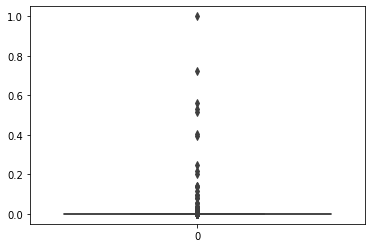

In [40]:
sns.boxplot(df['713bc35ae4a64ec4790712ab3ff2e7b0'])

In [41]:
df['142642bce57cac3a54f26d9c4a4ea164'].describe()

count   45,852.00000
mean         0.00102
std          0.01091
min          0.00000
25%          0.00000
50%          0.00000
75%          0.00006
max          1.00000
Name: 142642bce57cac3a54f26d9c4a4ea164, dtype: float64

<AxesSubplot:>

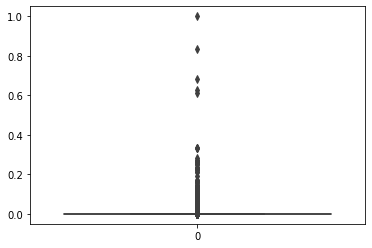

In [42]:
sns.boxplot(df['142642bce57cac3a54f26d9c4a4ea164'])

In [43]:
df['41b8f61fa021d3421510284f8e8ed8e6'].describe()

count   45,852.00000
mean         0.00099
std          0.01086
min          0.00000
25%          0.00000
50%          0.00000
75%          0.00009
max          1.00000
Name: 41b8f61fa021d3421510284f8e8ed8e6, dtype: float64

<AxesSubplot:>

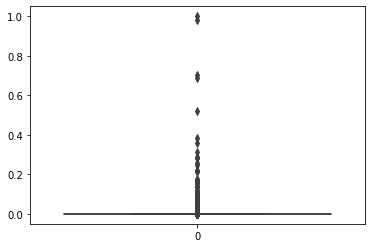

In [44]:
sns.boxplot(df['41b8f61fa021d3421510284f8e8ed8e6'])

In [45]:
df['de21a72f92151bd934313db21484d8db'].describe()

count   45,852.00000
mean         0.00114
std          0.00790
min         -0.00249
25%          0.00028
50%          0.00036
75%          0.00067
max          1.00000
Name: de21a72f92151bd934313db21484d8db, dtype: float64

<AxesSubplot:>

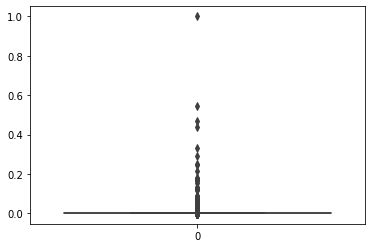

In [46]:
sns.boxplot(df['de21a72f92151bd934313db21484d8db'])

In [47]:
df['b55cf545a7986b074431f2d871729ce9'].describe()

count   45,852.00000
mean        -0.00105
std          0.00484
min         -0.00118
25%         -0.00118
50%         -0.00118
75%         -0.00118
max          1.00000
Name: b55cf545a7986b074431f2d871729ce9, dtype: float64

<AxesSubplot:>

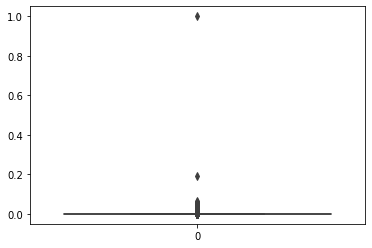

In [48]:
sns.boxplot(df['b55cf545a7986b074431f2d871729ce9'])

In [49]:
df['e2797b202accd48208bb55c5f42b3bd3'].describe()

count   45,852.00000
mean         0.00011
std          0.00875
min         -0.00036
25%         -0.00036
50%         -0.00036
75%         -0.00036
max          1.00000
Name: e2797b202accd48208bb55c5f42b3bd3, dtype: float64

<AxesSubplot:>

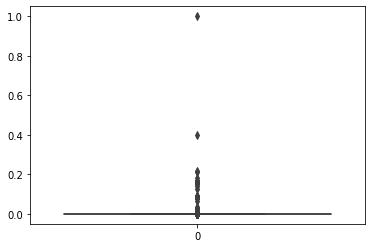

In [50]:
sns.boxplot(df['e2797b202accd48208bb55c5f42b3bd3'])

In [51]:
df['0866c8069f8eb9325d7aff3bc11aa4c6'].describe()

count   45,852.00000
mean         0.00003
std          0.00638
min         -0.36055
25%         -0.00001
50%         -0.00001
75%         -0.00001
max          1.00000
Name: 0866c8069f8eb9325d7aff3bc11aa4c6, dtype: float64

<AxesSubplot:>

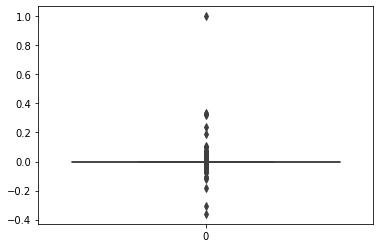

In [52]:
sns.boxplot(df['0866c8069f8eb9325d7aff3bc11aa4c6'])

In [53]:
df['d34fdde10bbb782474b10a70e8afe0f1'].describe()

count                           45,852.00000
mean       -43,154,834,910,628,003,840.00000
std        245,272,981,782,592,913,408.00000
min     -7,049,239,999,999,999,213,568.00000
25%           -999,999,999,999,999,872.00000
50%           -999,999,999,999,999,872.00000
75%                                  0.00000
max                                  0.00000
Name: d34fdde10bbb782474b10a70e8afe0f1, dtype: float64

<AxesSubplot:>

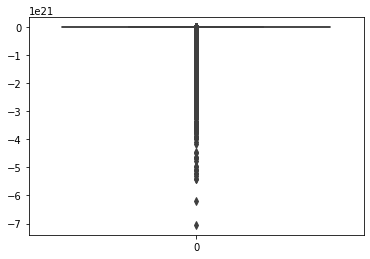

In [54]:
sns.boxplot(df['d34fdde10bbb782474b10a70e8afe0f1'])

In [55]:
df['c82fc9c0e6b2751df53d7dd5c468de67'].describe()

count   45,852.00000
mean         0.00018
std          0.00733
min         -0.00002
25%          0.00000
50%          0.00001
75%          0.00003
max          1.00000
Name: c82fc9c0e6b2751df53d7dd5c468de67, dtype: float64

<AxesSubplot:>

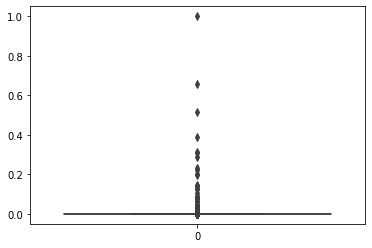

In [56]:
sns.boxplot(df['c82fc9c0e6b2751df53d7dd5c468de67'])

In [57]:
df['f9608069a551280acfd81ef612ffaaa3'].describe()

count                             45,852.00000
mean        -125,999,783,486,133,338,112.00000
std        2,427,300,652,620,006,293,504.00000
min     -141,999,999,999,999,987,417,088.00000
25%             -999,999,999,999,999,872.00000
50%             -999,999,999,999,999,872.00000
75%                                    0.00000
max                                    0.00000
Name: f9608069a551280acfd81ef612ffaaa3, dtype: float64

<AxesSubplot:>

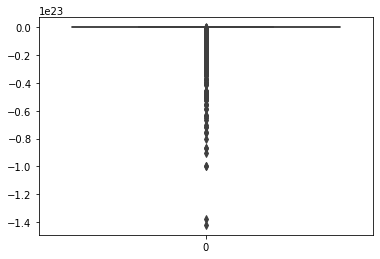

In [58]:
sns.boxplot(df['f9608069a551280acfd81ef612ffaaa3'])

In [59]:
df['8e78b08a9f5993a6c3ac4bceef7a8dd8'].describe()

count   45,852.00000
mean         0.00426
std          0.01861
min          0.00000
25%          0.00000
50%          0.00000
75%          0.00131
max          1.00000
Name: 8e78b08a9f5993a6c3ac4bceef7a8dd8, dtype: float64

<AxesSubplot:>

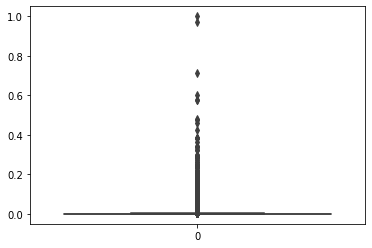

In [60]:
sns.boxplot(df['8e78b08a9f5993a6c3ac4bceef7a8dd8'])

In [61]:
df['cbdcd5b4417b44615f4205f532c09bf8'].describe()

count   45,852.00000
mean         0.00015
std          0.00691
min          0.00000
25%          0.00000
50%          0.00000
75%          0.00000
max          1.00000
Name: cbdcd5b4417b44615f4205f532c09bf8, dtype: float64

<AxesSubplot:>

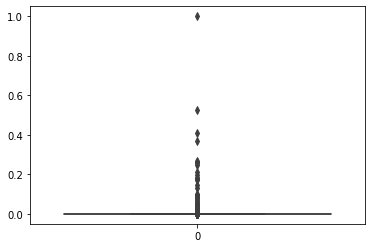

In [62]:
sns.boxplot(df['cbdcd5b4417b44615f4205f532c09bf8'])

In [63]:
df['de41cfed08599c3ed288a56edcc5c768'].describe()

count   45,852.00000
mean        -0.00217
std          0.00746
min         -0.00269
25%         -0.00269
50%         -0.00269
75%         -0.00269
max          1.00000
Name: de41cfed08599c3ed288a56edcc5c768, dtype: float64

<AxesSubplot:>

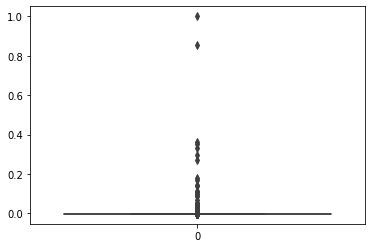

In [64]:
sns.boxplot(df['de41cfed08599c3ed288a56edcc5c768'])

In [65]:
df['7e9b2e50b011024e81f5c646fb436e28'].describe()

count                            45,852.00000
mean        -66,148,841,028,548,976,640.00000
std         372,591,061,418,714,923,008.00000
min     -16,258,219,999,999,998,033,920.00000
25%            -999,999,999,999,999,872.00000
50%            -999,999,999,999,999,872.00000
75%                                   0.00000
max                                   0.00000
Name: 7e9b2e50b011024e81f5c646fb436e28, dtype: float64

<AxesSubplot:>

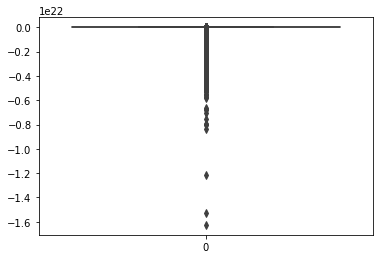

In [66]:
sns.boxplot(df['7e9b2e50b011024e81f5c646fb436e28'])

In [ ]:
# Выбросы не повлияли на результат
#drop_bad_rows('713bc35ae4a64ec4790712ab3ff2e7b0', 15000)
#drop_bad_rows('142642bce57cac3a54f26d9c4a4ea164', 15000)
#drop_bad_rows('41b8f61fa021d3421510284f8e8ed8e6', 20000)
#drop_bad_rows('de21a72f92151bd934313db21484d8db', 1000)
#drop_bad_rows('b55cf545a7986b074431f2d871729ce9', 2000)
#drop_bad_rows('e2797b202accd48208bb55c5f42b3bd3', 2000)
#drop_bad_rows('0866c8069f8eb9325d7aff3bc11aa4c6', 150000)
#drop_bad_rows('c82fc9c0e6b2751df53d7dd5c468de67', 40000)
#drop_bad_rows('d34fdde10bbb782474b10a70e8afe0f1', 6000)
#drop_bad_rows('f9608069a551280acfd81ef612ffaaa3', 120000)
#drop_bad_rows('8e78b08a9f5993a6c3ac4bceef7a8dd8', 200000)
#drop_bad_rows('cbdcd5b4417b44615f4205f532c09bf8', 60000)
#drop_bad_rows('7e9b2e50b011024e81f5c646fb436e28', 14000)
#drop_bad_rows('de41cfed08599c3ed288a56edcc5c768', 500)

In [68]:
# Нормализация тоже ничего не дала

# for column in df_num.columns:
#     max_val = max(df[column])
#     df[column] = df[column] / max_val

### Построение модели

In [98]:
#Выделяем отдельно признаки, отдельно целевую функцию
X = df.drop('f_triggered', axis=1)
y = df['f_triggered']

In [99]:
#кодируем 2 категориальных признаков
X = pd.get_dummies(X, columns=["64879933ebbcd196512dd71dede1b7fc"])
X = pd.get_dummies(X, columns=["b62f1cae6504d09ae4456042bc924802"])

In [100]:
X.head()

,snapshot_dt,a76154d74182dbdbe69cc30b71b94709,713bc35ae4a64ec4790712ab3ff2e7b0,142642bce57cac3a54f26d9c4a4ea164,41b8f61fa021d3421510284f8e8ed8e6,d70cf72daf09e847b9d98f5cd110e874,20954702b0ca458c1b9cc94a2149dfae,de21a72f92151bd934313db21484d8db,6e3c7ee1446922e9affc2dec6d8515f5,c4e258b20763ff2f5eb3a9c0051b79f9,56c259bfa606793bcebaab86f6b85433,1674cc7109143930d7062cf2bd15bc7a,b55cf545a7986b074431f2d871729ce9,e5b53d22fc96aa7d26dc24ae635738e3,1d211cea131c727b11e844a32fecdf60,e2797b202accd48208bb55c5f42b3bd3,56b9387690aec4bea7c0ead0cd2e24f7,0866c8069f8eb9325d7aff3bc11aa4c6,d34fdde10bbb782474b10a70e8afe0f1,9592aaf089727a294080f269ded5b792,6b5813ceabe68652ddab5a4aa9b721e0,c82fc9c0e6b2751df53d7dd5c468de67,cb943d8843fff2f8467e9302993102de,c6f4e2f63b588bd5687ea6355b58b715,a7e2d20b01d09c3dc6c3e7597ba74ab3,234f65a21bdae522ae9e58d00af11dcf,519053282a77e76f836c4e2de8b729e1,f9608069a551280acfd81ef612ffaaa3,51cb8124c134e01bff98d8e796f87f5a,8e78b08a9f5993a6c3ac4bceef7a8dd8,5d16d06d10a707e2fcdec6f8fc8c4430,d459ebf68fc2817262bbdf585ee417fa,3bd82d077c83e58e0682d35477517cf0,e4c6835684496e9fa5c8292c8bcaa4b3,b595cbe5ed2d1a3b983c039ae8ff405f,26ead531bb1ccaad478f1989fc1c8d9b,cbdcd5b4417b44615f4205f532c09bf8,de41cfed08599c3ed288a56edcc5c768,7218c484a45b5cf830285bff9b436a9e,9a97b46bc29290671213a1d7f21016b9,8ce7e1924c8891f9ca267c926a71d4ad,7e9b2e50b011024e81f5c646fb436e28,5a105e8b9d40e1329780d62ea2265d8a,ad0234829205b9033196ba818f7a872b,64879933ebbcd196512dd71dede1b7fc_016,64879933ebbcd196512dd71dede1b7fc_017,64879933ebbcd196512dd71dede1b7fc_018,64879933ebbcd196512dd71dede1b7fc_019,64879933ebbcd196512dd71dede1b7fc_01A,64879933ebbcd196512dd71dede1b7fc_unknown,b62f1cae6504d09ae4456042bc924802_016,b62f1cae6504d09ae4456042bc924802_017,b62f1cae6504d09ae4456042bc924802_018,b62f1cae6504d09ae4456042bc924802_019,b62f1cae6504d09ae4456042bc924802_01A,b62f1cae6504d09ae4456042bc924802_01B,b62f1cae6504d09ae4456042bc924802_01C,b62f1cae6504d09ae4456042bc924802_unknown
0,1525132800,0.00000,-1.00000,0.00000,0.00000,-1.00000,-1.00000,0.11249,0.00000,0.00000,0,2,-1.00000,-1.00000,0.00000,-1.00000,17.00000,-1.00000,-1.00000,-1.00000,-1.00000,0.00000,0.00000,-1.00000,-1.00000,-1.00000,-1.00000,0.00000,-1.00000,0.00000,-1.00000,-1.00000,0.00000,-1.00000,-1.00000,-1.00000,0.00000,-1.00000,0.00000,-1.00000,1.00000,-1.00000,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1,1543622400,1.00000,0.15990,0.00000,21.62523,-1.00000,0.00000,0.00000,0.00000,0.05607,0,6,-1.00000,-1.00000,-1.00000,-1.00000,17.00000,-1.00000,-1.00000,-1.00000,-1.00000,0.40865,0.01869,0.00000,-1.00000,-1.00000,-1.00000,0.00000,0.00000,"2,501.00000",-1.00000,-1.00000,0.00000,-1.00000,-1.00000,0.00000,0.00000,-1.00000,0.00000,-1.00000,0.00000,-1.00000,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,1551398400,0.00000,4.86667,1.61290,0.00000,-1.00000,-1.00000,3.34294,0.00000,0.00000,0,0,-1.00000,0.00000,0.33333,-1.00000,17.00000,0.00000,-1.00000,-1.00000,0.00000,1.13528,0.08065,-1.00000,3.00000,0.00000,0.00000,0.00000,2.00000,862.12000,0.00000,-0.23196,0.00000,-1.00000,-1.00000,-0.46764,0.00000,-1.00000,0.00000,0.80000,0.00000,-1.00000,2,2,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,1533081600,0.17835,3.09240,19.20701,0.00000,-1.00000,0.00000,0.24108,0.00000,0.11111,0,0,0.00000,-1.00000,1.00000,-1.00000,17.00000,-1.00000,0.00000,0.00000,-1.00000,0.02332,0.00855,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,0.00000,"7,896.20000",-1.00000,-1.00000,0.00000,-1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-1.00000,0.00000,0.00000,3,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
7,1546300800,0.17835,4.86667,0.00000,0.00000,-1.00000,-1.00000,0.11747,0.03704,0.00000,0,2,-1.00000,0.00000,0.00000,-1.00000,17.00000,0.00000,0.00000,-0.45807,0.00000,10.04580,0.00000,-1.00000,1.27273,0.00000,0.00000,-1.00000,3.00000,0.00000,0.00000,0.00000,0.00000,0.33333,0.00000,-0.46764,0.00000,-1.00000,0.00000,-1.00000,0.00000,0.00000,1,2,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [101]:
#разбиваем на train и test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [102]:
X_train.shape

(32096, 58)

In [103]:
X_test.shape

(13756, 58)

In [104]:
# Определим функцию для подсчета метрики (roc_auc, gini)

def getGiniMetrics(model):
    pred_prob_train = model.predict_proba(X_train)
    preds_train = pred_prob_train[:,1]
    fpr_train, tpr_train, threshold = metrics.roc_curve(y_train, preds_train)
    roc_auc_train = metrics.auc(fpr_train, tpr_train)
    #print(roc_auc_train)
    
    pred_prob_test = model.predict_proba(X_test)
    preds_test = pred_prob_test[:,1]
    fpr_test, tpr_test, threshold = metrics.roc_curve(y_test, preds_test)
    roc_auc_test = metrics.auc(fpr_test, tpr_test)
    #print(roc_auc_test)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr_train, tpr_train, 'b', label = 'Gini train = %0.2f' % (roc_auc_train*2-1))
    plt.plot(fpr_test, tpr_test, 'g', label = 'Gini test = %0.2f' % (roc_auc_test*2-1))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

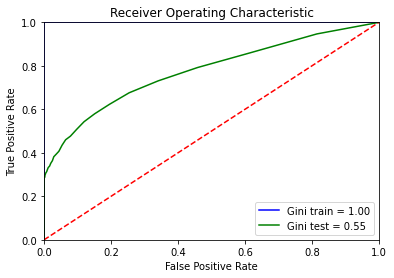

In [105]:
#Попробуем модель случайного леса

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

rf_model = RandomForestClassifier(criterion='gini') 
rf_model.fit(X_train,y_train)
getGiniMetrics(rf_model)

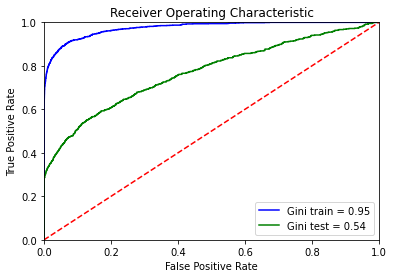

In [106]:
#Попробуем модель градиентного бустинга: xgboost
from xgboost import XGBClassifier
from sklearn import metrics

xgb_model = XGBClassifier()
xgb_model.fit(X_train,y_train)
getGiniMetrics(xgb_model)

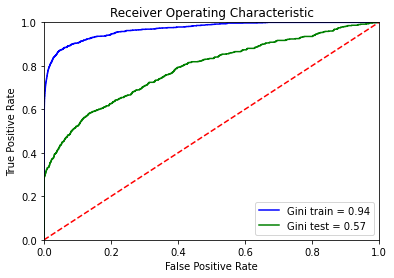

In [107]:
#Попробуем модель градиентного бустинга: lightgbm

from lightgbm import LGBMClassifier
from sklearn import metrics

lgbm_model = LGBMClassifier()
lgbm_model.fit(X_train, y_train)
getGiniMetrics(lgbm_model)

Видно, что модели сильно переобучаются на тренировочных данных, а на тестовых показывают результат много хуже

In [108]:
# поиск оптимальных параметров
from sklearn import metrics 
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.preprocessing import StandardScaler 
from lightgbm import LGBMClassifier

param_grid = {
    "n_estimators": [100, 200], 
    "max_depth": [2, 3, 4], 
    "learning_rate": [0.1, 0.2, 0.3],
    "reg_lambda": [0, 1, 10],
}

lgbm= LGBMClassifier()
grid_cv = RandomizedSearchCV(lgbm, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")

grid_cv.fit(X_train, y_train)
print(grid_cv.best_score_)
print(grid_cv.best_estimator_.get_params())

0.7921265046525839
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.2, 'max_depth': 2, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 10, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


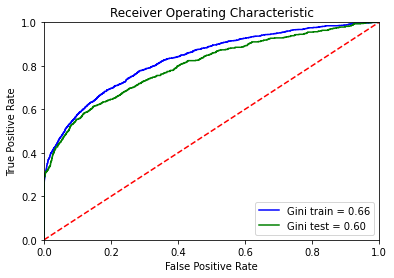

In [111]:
getGiniMetrics(grid_cv.best_estimator_)

In [112]:
# поиск оптимальных параметров
from sklearn import metrics 
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.preprocessing import StandardScaler 
from xgboost import XGBClassifier

param_grid = {
    "n_estimators": [100, 200], 
    "max_depth": [2, 3, 4], 
    "learning_rate": [0.1, 0.2, 0.3],
    "reg_lambda": [0, 1, 10],
}

xgb = XGBClassifier()
grid_model = RandomizedSearchCV(xgb, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")

grid_model.fit(X_train, y_train)
print(grid_model.best_score_)
print(grid_model.best_estimator_.get_params())

0.7943016937620534
{'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0, 'gpu_id': -1, 'grow_policy': 'depthwise', 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.1, 'max_bin': 256, 'max_cat_threshold': 64, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 3, 'max_leaves': 0, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 0, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'sampling_method': 'uniform', 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}


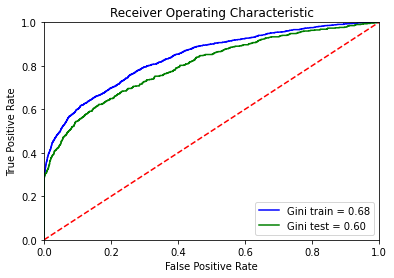

In [113]:
getGiniMetrics(grid_model.best_estimator_)

In [114]:
# Попробуем дополнить класс меньшинства случайной избыточной выборкой (копирование случайным образом примеры класса)
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=777)
X_ROS, y_ROS = ros.fit_resample(X_train, y_train)

In [115]:
X_ROS.shape

(61380, 58)

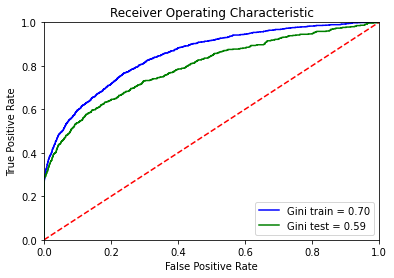

In [118]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, reg_lambda=1)
xgb.fit(X_ROS,y_ROS)
getGiniMetrics(xgb)

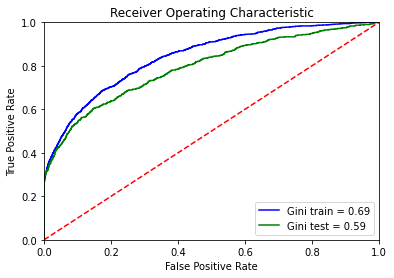

In [119]:
from lightgbm import LGBMClassifier
from sklearn import metrics

lgbm_model = LGBMClassifier(max_depth=2, learning_rate=0.2, reg_lambda=10)
lgbm_model.fit(X_ROS,y_ROS)
getGiniMetrics(lgbm_model)

Вывод: лучшее качество модели удалось достичь с помощью XGBClassifier с подбором гиперпараметров через RandomizedSearchCV

Коэффициент джинни:

На тренировочной подвыборке = 68

На тестовой подвыборке = 60